In [1]:
import realweather as rw

import torch
from torch.utils.data.dataloader import DataLoader
import torch.optim as optim
import numpy as np
from torch import nn
from torch.utils.data import SubsetRandomSampler
from sklearn.model_selection import train_test_split

import torchvision.transforms as T

%env CUDA_VISIBLE_DEVICES=1

env: CUDA_VISIBLE_DEVICES=1


In [2]:
device = (
    "cuda:0" if torch.cuda.is_available() else "cpu"
)  # 0 indicates the GPU you gonna use
print(f"Using {device} device")

Using cuda:0 device


In [3]:
def train_epoch(net, dataloader, optimizer, loss_function):
    """Trains the network (forwardprop, loss, backprop) for one epoch"""

    epoch_loss = 0
    train_steps = 0

    # Training
    net.train()
    for batch in dataloader:

        # get the inputs; batch is a list of [inputs, labels]
        X, y = batch
        X = X.to(device)
        y = y.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        output = net(X)
        loss = loss_function(output, y)
        epoch_loss += loss.item()
        train_steps += 1
        loss.backward()
        optimizer.step()

    return epoch_loss, train_steps

In [4]:
def eval_epoch(net, dataloader, loss_function):
    """Trains the network (forwardprop, loss, backprop) for one epoch"""

    epoch_loss = 0
    eval_steps = 0

    # Training
    net.eval()
    for batch in dataloader:

        # get the inputs; batch is a list of [inputs, labels]
        X, y = batch
        X = X.to(device)
        y = y.to(device)
        
        output = net(X)
        loss = loss_function(output, y)
        epoch_loss += loss.item()
        eval_steps += 1

    return epoch_loss, eval_steps

In [5]:
def train_nn(config, dataloaders, net):
    train_dl, test_dl = dataloaders
    loss_function = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=config["lr_init"])
    for epoch in range(config["epochs"]):
        train_loss, train_steps = train_epoch(net, train_dl, optimizer, loss_function)
        eval_loss, eval_steps = eval_epoch(net, test_dl, loss_function)
        print(f"EPOCH {epoch} : TRAIN_LOSS={train_loss / train_steps} | VAL_LOSS={eval_loss / eval_steps}")

In [6]:
rw.clean_dataset("paris_seine")

images = rw.open_images("paris_meurice")

exclusion_list = [
    "dist_sunrise",
    "dist_sunset",
    "temp",
    "feels_like",
    "pressure",
    "humidity",
    "dew_point",
    "uvi",
#     "clouds",
    "visibility",
    "wind_speed",
    "wind_deg",
    "ceiling",
    "precipitation",
    "pop",
    "weather",
]

data = rw.open_weather_data_accu("paris_meurice", scale_data=True, exclusion_list=exclusion_list)

if len(images) > len(data):
    images = images[(len(images) - len(data)):]

day_images = []
for i, img in enumerate(images):
    if img.flatten().mean() > 0.4:
        day_images.append(i)


In [8]:
transforms = torch.nn.Sequential(
#     T.RandAugment(),
    T.RandomRotation(degrees=45),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomVerticalFlip(p=0.5),
    T.ColorJitter(brightness=.5, hue=.3),
    T.RandomCrop(size=(112, 112)),
)

In [9]:
model = torch.hub.load("pytorch/vision:v0.10.0", "resnet18", pretrained=True)
model.fc = nn.Linear(512, 1)
model = model.to(device)

aug_dataset = rw.RealWeatherDataset(images, data, transform=transforms, device=device)
reg_dataset = rw.RealWeatherDataset(images, data, device=device)

idx_train, idx_test = train_test_split(day_images, test_size=0.2, random_state=0)
# idx_train, idx_test = train_test_split(list(range(len(dataset))), test_size=0.2, random_state=0)

Using cache found in /home/tlaurent/.cache/torch/hub/pytorch_vision_v0.10.0
/home/tlaurent/.local/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/home/tlaurent/.local/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
len(idx_test) # 589

775

In [11]:
config = {"epochs": 50, "batch_size": 64, "lr_init": 0.00001}
train_dl = DataLoader(aug_dataset, batch_size=config["batch_size"], sampler=SubsetRandomSampler(idx_train))
test_dl = DataLoader(aug_dataset, batch_size=config["batch_size"], sampler=SubsetRandomSampler(idx_test))
train_nn(config, (train_dl, test_dl), model)

EPOCH 0 : TRAIN_LOSS=1.2125176665734272 | VAL_LOSS=0.962480943936568
EPOCH 1 : TRAIN_LOSS=0.8902036231391284 | VAL_LOSS=0.7446055916639475
EPOCH 2 : TRAIN_LOSS=0.7513011237796472 | VAL_LOSS=0.7329506644835839
EPOCH 3 : TRAIN_LOSS=0.7009437035541145 | VAL_LOSS=0.692327829507681
EPOCH 4 : TRAIN_LOSS=0.6781395844050816 | VAL_LOSS=0.6558456008250897
EPOCH 5 : TRAIN_LOSS=0.6658008281065493 | VAL_LOSS=0.5382179388633141
EPOCH 6 : TRAIN_LOSS=0.6430192060616552 | VAL_LOSS=0.5563273384020879
EPOCH 7 : TRAIN_LOSS=0.6277265871057705 | VAL_LOSS=0.6524829199680915
EPOCH 8 : TRAIN_LOSS=0.6051210432636495 | VAL_LOSS=0.5908142878459051
EPOCH 9 : TRAIN_LOSS=0.6074297069286814 | VAL_LOSS=0.5287096958893996
EPOCH 10 : TRAIN_LOSS=0.5846320652231878 | VAL_LOSS=0.540465907408641
EPOCH 11 : TRAIN_LOSS=0.5774737079532779 | VAL_LOSS=0.5371160232103788
EPOCH 12 : TRAIN_LOSS=0.5772799946823899 | VAL_LOSS=0.5172003117891458
EPOCH 13 : TRAIN_LOSS=0.5957859985682429 | VAL_LOSS=0.5670923590660095
EPOCH 14 : TRAIN_LO

In [12]:
test_dl = DataLoader(reg_dataset, batch_size=30, sampler=SubsetRandomSampler(idx_test))

In [13]:
X, y = next(iter(test_dl))
X = X.to(device)
# y = y.to(device)
y = model(X)

In [14]:
X = X.cpu().detach().numpy()
y = y.cpu().detach().numpy()
y = np.array([x[0] for x in y])
sorted_idx = np.argsort(y)
ys = y[sorted_idx]
Xs = X[sorted_idx]

In [15]:
id_list = []

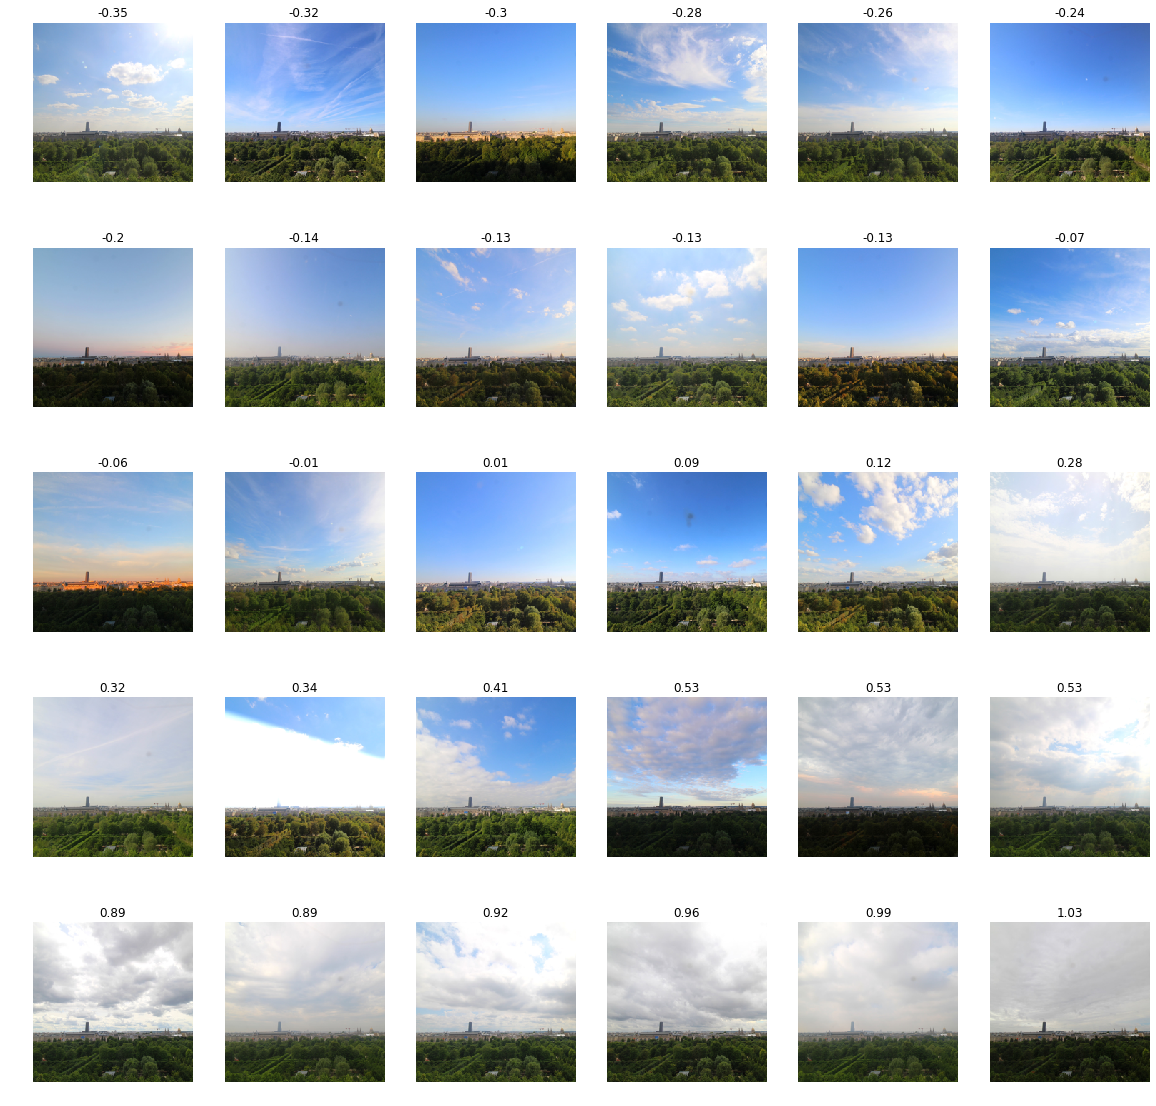

In [16]:
import numpy as np
import matplotlib.pyplot as plt

w = 10
h = 10
fig = plt.figure(figsize=(20, 20))
columns = 6
rows = 5
for i in range(columns*rows):
    img = np.moveaxis(Xs[i], 0, -1)
    fig.add_subplot(rows, columns, i + 1)
    plt.title(np.round(ys[i], 2))
    plt.axis('off')
    plt.imshow(img)
plt.show()

In [20]:
import os
from PIL import Image
def isolate_image(to_find, location):
    dataset = []
    for file in os.listdir(rw.images_dir[location]):
        if file.endswith(".jpg"):
            try:
                img = Image.open(os.path.join(rw.images_dir[location], file))
                arr = rw.process_image(img, location)
                img.close()
            except Exception as e:
                print(f"Exception with image {file}")
                with open(
                    os.path.join(rw.error_dir, file.replace(".jpg", ".txt")), "w"
                ) as f:
                    f.write(str(e))
                continue
            arr = (arr.astype(np.float32) / 255)
            if np.array_equal(arr, to_find):
                print(file)
                break
            
isolate_image(np.moveaxis(Xs[19], 0, -1), "paris_meurice")

1654781957_paris_meurice.jpg


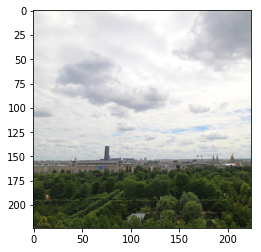

In [19]:
plt.imshow(np.moveaxis(Xs[19], 0, -1))

In [28]:
Xs[6].flatten().mean()

0.63993293

In [6]:
from PIL import Image
im = Image.open("meteo_paris_seine/images/1650632440_paris_seine.jpg")

In [12]:
im = im.crop(rw.image_crops["paris_seine"])
im = im.resize((224, 224))

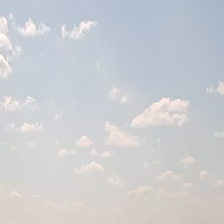

In [13]:
im

In [ ]:
###################################################################################################################

In [22]:
import glob
import os
dir_name = 'meteo_paris_meurice/images/'
# Get a list of files (file paths) in the given directory 
list_of_files = os.listdir(dir_name)
# get list of ffiles with size
files_with_size = [ (file_path, os.stat(dir_name + file_path).st_size) 
                    for file_path in list_of_files ]
# Iterate over list of tuples i.e. file_paths with size
# and print them one by one
delete_list = []

for file_path, file_size in files_with_size:
#     print(file_size, ' -->', file_path)
    if file_size == 170836:
        delete_list += ["meteo_paris_meurice/" + "images/" + file_path]
        delete_list += ["meteo_paris_meurice/" + "weather_data/" + file_path.split(".")[0] + ".json"]
        delete_list += ["meteo_paris_meurice/" + "weather_data_accu/" + file_path.split(".")[0] + ".json"]